This is the repository for the "Quantum transformer for High Energy Physics Analysis at the LHC", a Google Summer of Code 2023 project by ML4Sci instution QMLHeP group. The purpose of the project is to have a proof-of-concept Quantum Vision Transformer implementation for the jet data classification.

It is now possible to implement a hybrid QViT transformer on resized mnist data using this project. A blog about midterm progress can be found at:

https://medium.com/@eyupb.unlu/gsoc-2023-with-ml4sci-quantum-transformer-for-high-energy-physics-analysis-at-the-lhc-the-midterm-5cf454b9f12c

Warning: QVIT.pennylane is deprecated, this project only uses tensorcircuit with jax backend now.

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !git clone https://github.com/EyupBunlu/QViT_HEP_ML4Sci

<a target="_blank" href="https://colab.research.google.com/github/EyupBunlu/QViT_HEP_ML4Sci">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST
from torchvision import transforms
import h5py
if IN_COLAB: from QViT_HEP_ML4Sci.QViT import *
else: from QViT import *
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
device='cuda' # technically algorithm can be run on cpu but for speed reasons, it is not suggested.

Please first ``pip install -U cirq`` to enable related functionality in translation module


In [4]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
})

## First Method

The first method to achieve our goal will be reproducing the architecture in the paper ["Quantum Vision Transformers"](https://arxiv.org/pdf/2209.08167.pdf) (referred as QViT paper in the file) if possible.

Papers of interest

Conference Paper: https://indico.jlab.org/event/459/contributions/11832/ \
Beamsplitter Decomposition Paper: https://arxiv.org/pdf/2212.07389.pdf \
Beamsplitter Qumode Explanation: https://quantumcomputing.stackexchange.com/questions/32286/how-to-represent-beam-splitter-and-kerr-gates-as-basic-quantum-logic-gates\ \
QViT Paper: https://arxiv.org/pdf/2209.08167.pdf \

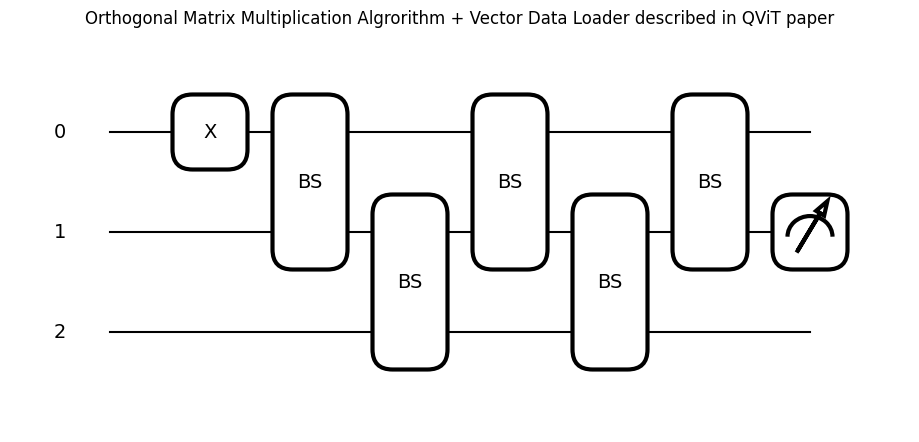

In [3]:
length = 3
qml.draw_mpl(mmult_bs,show_all_wires=True,wire_order=[i for i in range(length)])(torch.zeros(10),torch.ones(2))
q=plt.title('Orthogonal Matrix Multiplication Algrorithm + Vector Data Loader described in QViT paper')

The Beamsplitter gate mentioned in the paper only works with the qumodes. However it can be decomposed as the following combination of gates as explained in the paper
["Quantum Methods for Neural Networks and Application to Medical Image Classification"](https://arxiv.org/pdf/2212.07389.pdf)

Text(0.5, 1.0, 'BeamSplitter Equivalent Structure')

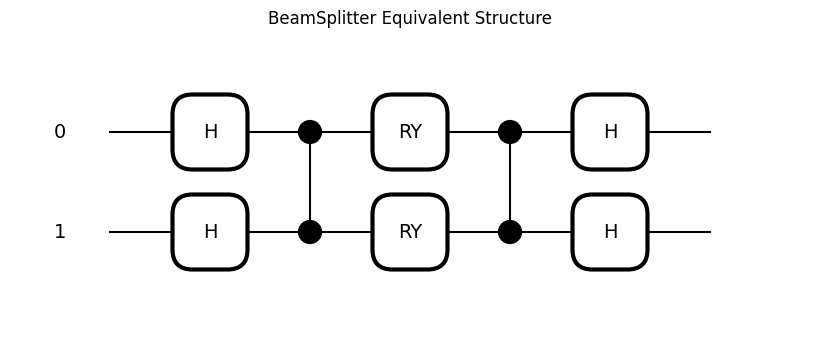

In [4]:
qml.draw_mpl(rbs,show_all_wires=True)([0,1],torch.tensor([0]))
plt.title('BeamSplitter Equivalent Structure')

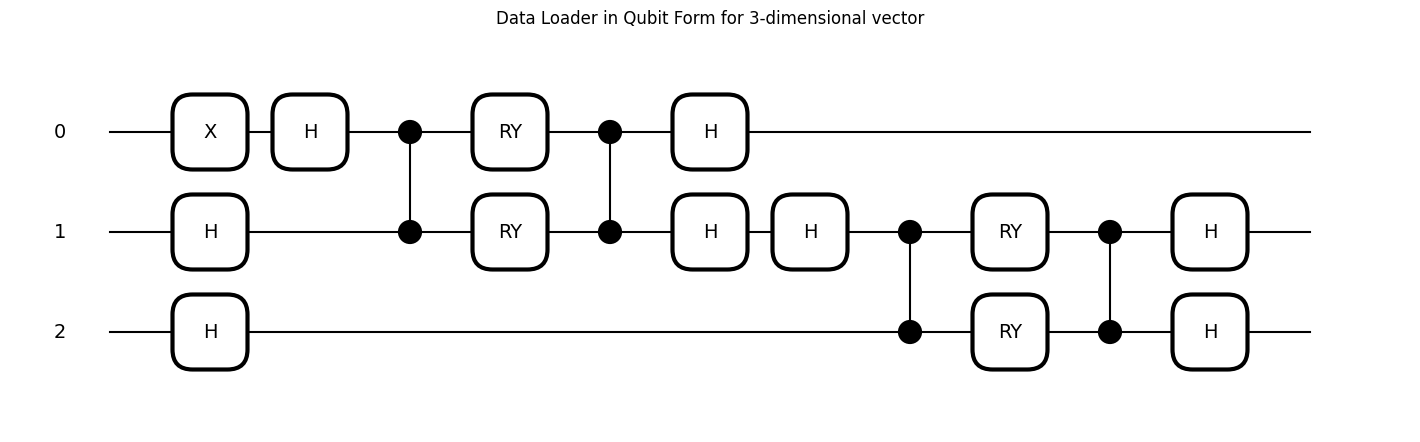

In [5]:
qml.draw_mpl(vector_loader,show_all_wires=True,wire_order=[i for i in range(3)])(torch.ones(2))
q=plt.title('Data Loader in Qubit Form for 3-dimensional vector')
plt.savefig('loader1')

Suggested data loader takes n-1 parameters to load length n data.
Data loader circuit can be expressed as the following.

$$\Psi = \left[\Sigma_{i=0}^{n-2} \left(\Pi^{i-1}_{j=0}\sin \alpha_j \right)e_i \cos \alpha_i \right]+\left(\Pi^{n-1}_{j=0}\sin \alpha_j \right)e_{n-1}$$.
Therefore, one can load normalized vector $x_i$ using the following parameters:
$$\alpha_0 = cos^{-1}(x_0)$$
$$\alpha_i = cos^{-1}\left(x_i  \left[1-\Sigma_{j=0}^{i-1}x_j^2\right]^{-1/2}\right)$$


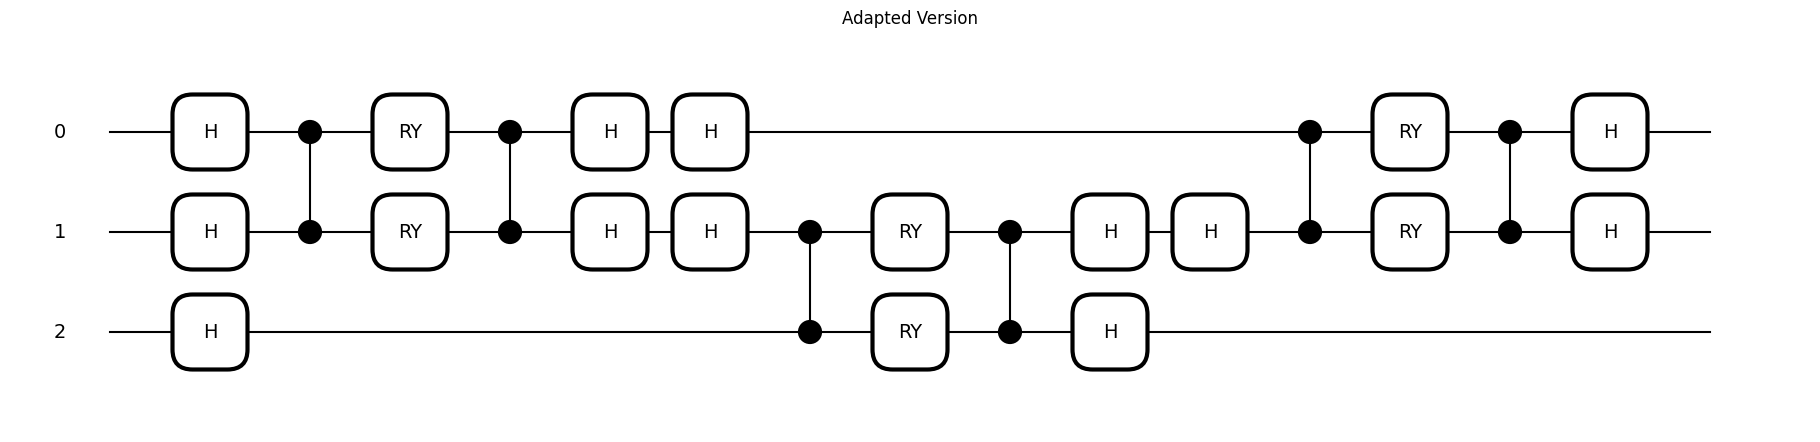

In [6]:
qml.draw_mpl(mmult,show_all_wires=False,wire_order=[i for i in range(5)])(torch.zeros(10),None,3)
q=plt.title('Adapted Version')

### Vector Loader Demonstration

In [7]:
X = torch.tensor([1/2,1/2,1/np.sqrt(2)],requires_grad=False)
alphas = convert_array(X)
wires = [ str(i) for i in range (X.shape[0])]

Loading X: [0.5        0.5        0.70710678]


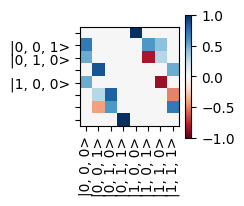

In [8]:
plot_opm(vector_loader,[alphas,wires],wire_order = None)
print('Loading X: {}'.format(X.numpy()))

### Matrix Loader Demonstration

Matrix loader used in the QViT paper consists of multiple vector loaders and some CNOT gates. In order to load a matrix of nxd, one needs to use n+1 many data loaders and n+d qubits. It encodes the data to the qubits as,
$$|\Psi>=\sum_{i,j}^{n,d} \frac{X_{ij}}{||X||} |m_i> \otimes |e_j> $$
where $|m_i>$ are magnitude qubits and $|e_j>$ are vector qubits.

In [9]:
X = torch.tensor([[1,1,1],[0,1,0],[0,0,1]],requires_grad=False)
nrow,ncolumn = X.shape
mag_wires = [ '||X||_'+str(i) for i in range (nrow)]
wires = [ str(i) for i in range (ncolumn)]

mag_alphas,alphas = convert_matrix(X)

In [10]:
mag_alphas

tensor([0.6847, 0.7854])

Data Loader


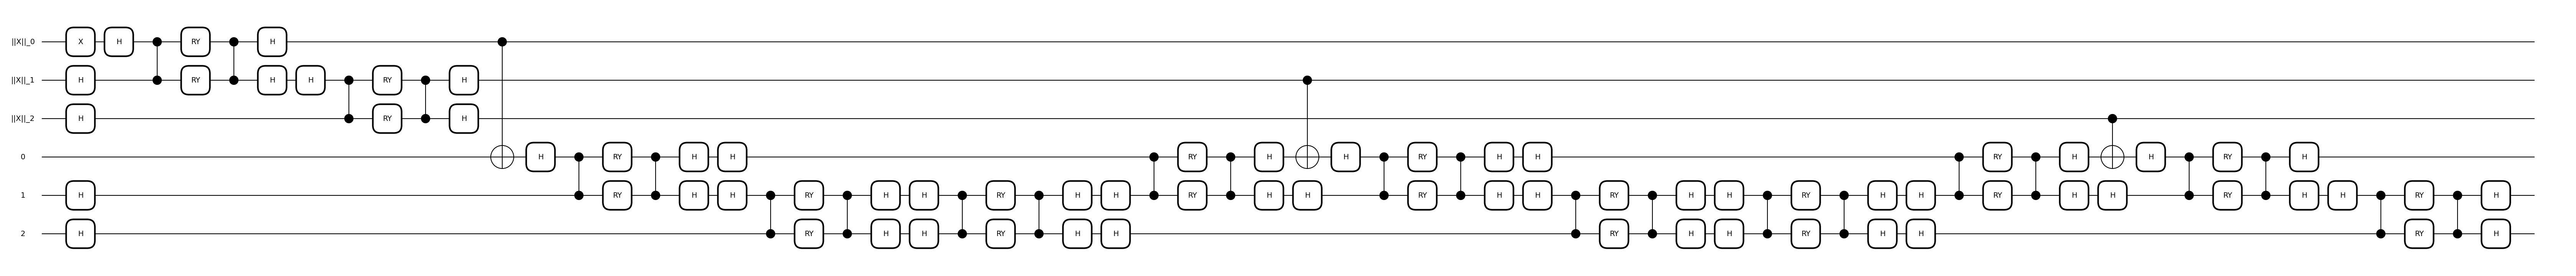

In [11]:
qml.draw_mpl(matrix_loader,show_all_wires=True,wire_order=mag_wires+wires)(mag_alphas,alphas,mag_wires,wires)
# q=plt.title('$\huge{Circuit Form}$')
print('Data Loader')

Text(0.5, 1.0, "Matrix Loader's Matrix Representation for Loading \n X=[[1 1 1]\n [0 1 0]\n [0 0 1]]")

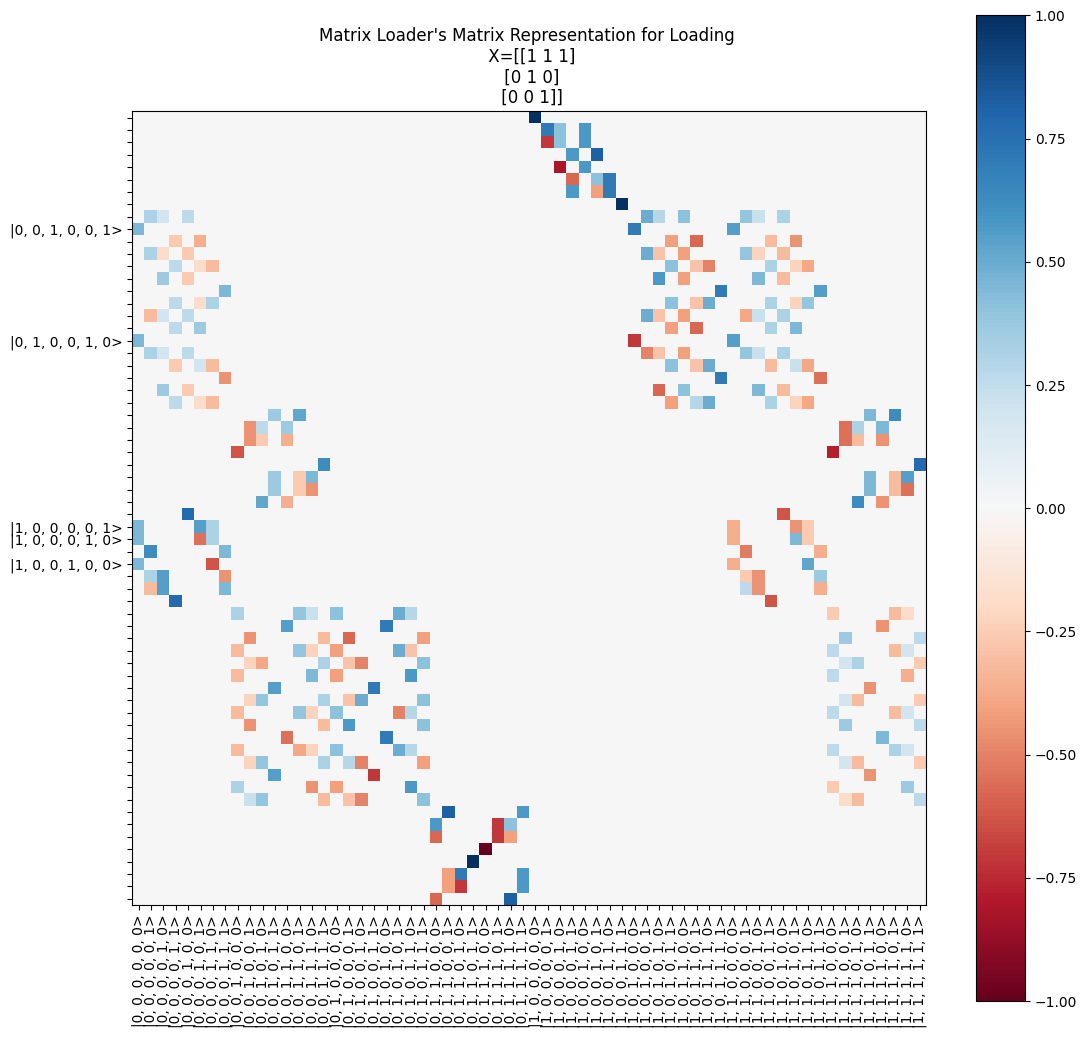

In [12]:
plot_opm(matrix_loader,(mag_alphas,alphas,mag_wires,wires),wire_order = mag_wires+wires)
plt.title('Matrix Loader\'s Matrix Representation for Loading \n X={}'.format(X.numpy()))

### Demonstration of $A_{ij}=x_i^TWx_j$ calculation

In order to calculate the $A_{ij}=x_i^TWx_j$, one needs to load the $|x_j>$ then apply W then load $<x_i|$. \
In order to achieve this we will need d many qubits where our data is a $nxd$ matrix.\
We need to make sure that we multiply our output with the norms of $x_i$ and $x_j$ since our data loader only takes unit normalized vectors as input. \
For this demonstration, A random orthogonal matrix is created and the loss function is set such that it is minimum if W is that matrix. In addition, I took the absolute value of Y as this method doesn't retrieve the sign.

In [13]:
torch.manual_seed(1)
X = torch.rand(5,2,3)*2-1
X = X/(X**2).sum(axis=-1).sqrt()[...,None]
n = X.shape[1]+1
d = X.shape[2]
n_epoch = 100

In [14]:
W_ideal = torch.rand(d,d)-1/2
W_ideal = W_ideal-W_ideal.T
W_ideal = (torch.eye(d)-W_ideal)@(torch.eye(d)+W_ideal).inverse()

Y = torch.einsum('nik,kl,njl->nij',X,W_ideal,X)

alphas = convert_array(X)
norms = (X**2).sum(axis=-1).sqrt()
wires=[i for i in range(d+1)]

(<Figure size 1900x500 with 1 Axes>, <Axes: >)

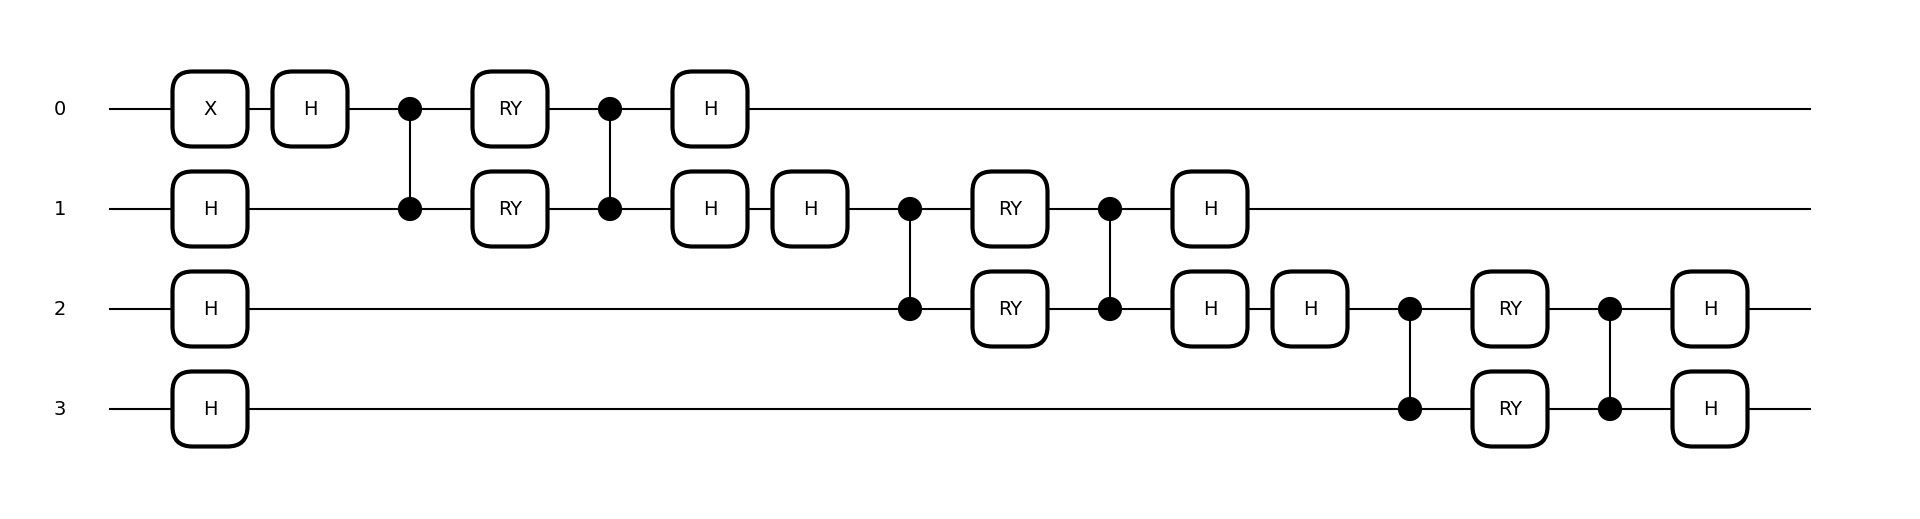

In [15]:
qml.draw_mpl(vector_loader)(torch.rand(d),wires,True,False)

In [16]:
alphas.shape

torch.Size([5, 2, 2])

In [17]:


loss_fn = lambda yhat,y :((yhat-y)**2).sum(axis=[-1,-2]).sqrt().mean()
bar = tqdm(range(n_epoch))
QLayer = circuit_to_layer(compute_attention_element,wires,{'phi':(n**2-n)//2},device=device)
optim=torch.optim.Adam(QLayer.parameters(),lr=5e-2)

for i in bar:
    yhat = []
    optim.zero_grad()
    yhat = compute_attention(alphas.to(device),norms.to(device),QLayer)
    loss_ = loss_fn(yhat,Y.to(device))
    bar.set_postfix_str(loss_.item())
    loss_.backward()
    optim.step()



  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
phi = list( QLayer.parameters())[0]

In [19]:
print(W_ideal)

tensor([[ 0.5657,  0.7179,  0.4057],
        [-0.8007,  0.5958,  0.0622],
        [-0.1971, -0.3600,  0.9119]])


### Matrix Multiplication on X Demonstration

It would be possible to start creating a transformer once we can perform orthogonal matrix multiplication on the loaded data vector and retrieve the signs. This part will be added later for completeness but it wouldn't be used as it demands too many qubits.

$\textbf{Soon to be Added}$

### Hybrid Transformer

A hybrid transformer structure is implemented below. It is almost identical to a classic ViT except
$$\text{Softmax}\left( \frac{(W_KX) (W_QX)^T)}{\sqrt n}\right)$$
calculation is replaced with
$$\text{Softmax}\left( \frac{QC(W,X)}{\sqrt n}\right)$$
where X (bxnxd) is the input.

QC in this method only calculates
$A_{ij}=x_i^TWx_j$


This approach requires retrieving expectation value of the first qubit for $n^2$ many times where the circuit has d qubits.
Therefore quantum part of this circuit would have $O(n^2f(d))$ where f(d) is the time required for the circuit to retrieve the expectation value.
On the other hand, using a classical method to perform the same operation would have time complexity of $O(nd^2+n^2d)$.

The experimental calculation of f(d) is shown below



Text(0, 0.5, 'f(d) in seconds')

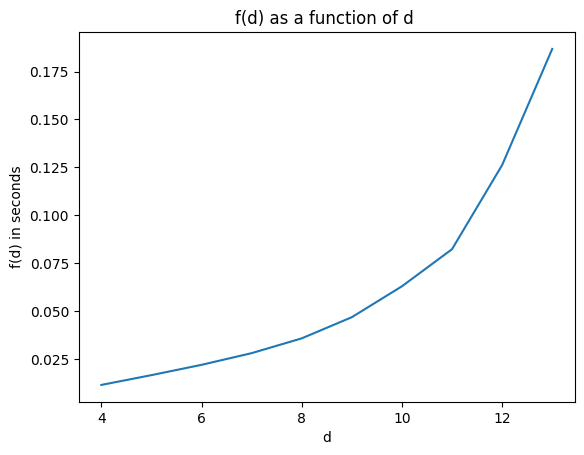

In [20]:
t={}
l=[]
n=10
for i in range(4,14,1):
    X=convert_array(torch.rand(2,i))
    A = circuit_to_layer(compute_attention_element,wires=list(range(i+1)),pars={'phi':(i**2-i)//2})
    t_ = time.time()
    for _ in range(n):A(X.flatten())
    t[i]= (time.time()-t_)/n
    l.append(i)

plt.plot(t.keys(),[t[i] for i in t.keys()])
plt.title("f(d) as a function of d ")
plt.xlabel('d')
plt.ylabel('f(d) in seconds')

In [21]:
t

{4: 0.011350345611572266,
 5: 0.016463041305541992,
 6: 0.021843504905700684,
 7: 0.027939772605895995,
 8: 0.03567056655883789,
 9: 0.046725010871887206,
 10: 0.06286625862121582,
 11: 0.08224492073059082,
 12: 0.12619428634643554,
 13: 0.1868514060974121}

This is a big problem given we will need to perform this operation for $n_{\text{epoch}}n_{\text{samples}}n_{\text{layers}}n_{\text{heads}}n^2$ many times. If we wanted to implement this model for MNIST classification with 14 patches of 14 length arrays, two layers with two heads and 200 data points, an epoch would take $4*14^2*200*.07$ seconds or 10 hours on CPU, not including classical parts.


## Second Method

Papers of interest:\
[Quantum Self-Attention Neural Networks for Text Classification](https://arxiv.org/abs/2205.05625)

This approach is more computation friendly (at least for the case at hand) and more quantum circuit oriented. Instead of computing the coefficients of the attention that is clasiccal like, this approach uses key/query/value to calculate a corresponding key/query coefficient for each row and a vector for the values. Then, it calculates the coefficient constants as 
$$A_{ij} = -(K{i}-Q{j})^2 $$
$$K_{i} = <\Psi_i|U_K(\theta_K)^\dagger Z_1 U_K(\theta_K) |\Psi_i>  $$
$$Q_{i} = <\Psi_i|U_Q(\theta_Q)^\dagger Z_1 U_Q(\theta_Q) |\Psi_i>. $$
$|\Psi_s>$ is encoded version of the $s^{\text{th}}$ row vector and can be expressed as,

$$|\Psi_s> = \Pi_{i=0} RX(x_i) H^{\otimes n} |0^n>.$$

In order to obtain the value matrix we use the following method.
$$V_{ij} = <\Psi_i|U_K(\theta_K)^\dagger Z_j U_K(\theta_K) |\Psi_i>  $$
At the end our single head attention head is defined as,
$$\text{Self Attention(X,W_K,W_Q,W_V)}=\text{Softmax}\left(\frac{A}{d_k}\right)V$$

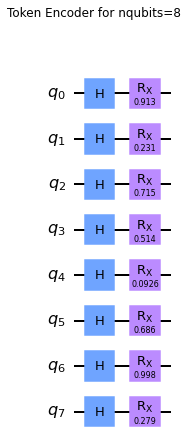

In [3]:
nqubits = 8
circuit = tc.Circuit(nqubits)
data = torch.rand(nqubits)
encode_token(circuit,data,nqubits)
# v_ansatz(c,torch.ones(8),torch.rand(24),8)
circuit.measure(0 )
circuit_qiskit=circuit.to_qiskit()
f=circuit_qiskit.draw(output="mpl")
f.suptitle('Token Encoder for nqubits=8')
f
# plt.title('Dataloader')

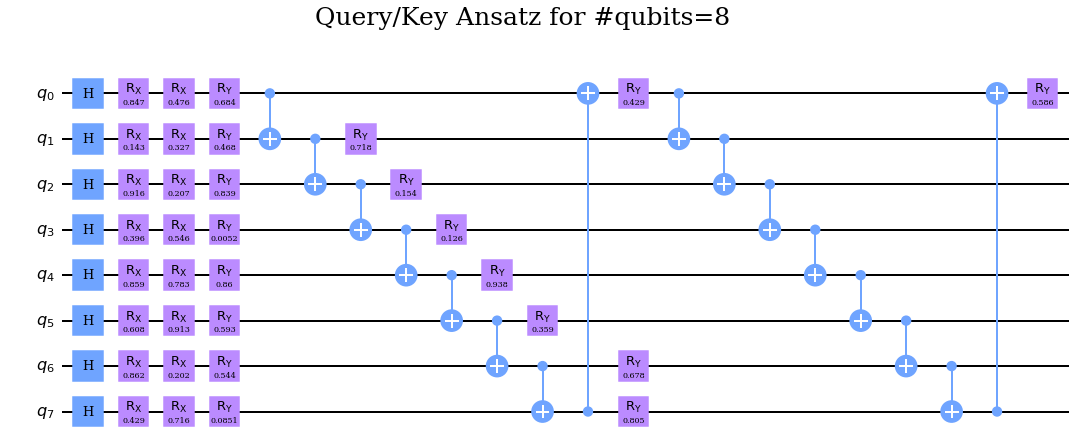

In [9]:
nqubits = 8
circuit = tc.Circuit(nqubits)
data = torch.rand(nqubits)
encode_token(circuit,data,nqubits)
qk_ansatz(circuit,data,torch.rand(3*nqubits+1),nqubits)
circuit.measure(0 )
circuit_qiskit=circuit.to_qiskit()
f=circuit_qiskit.draw(output="mpl")
f.suptitle('Query/Key Ansatz for #qubits=8',size=25)
f


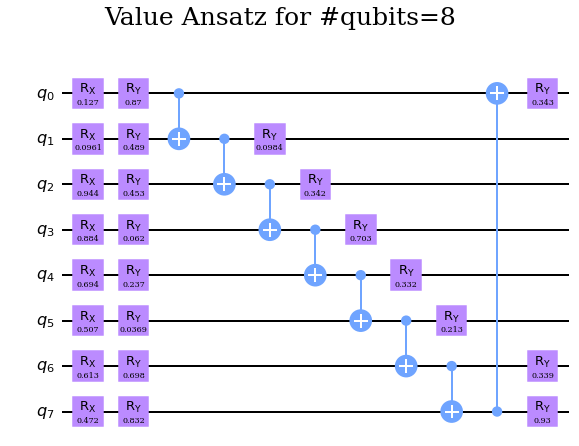

In [8]:
nqubits = 8
circuit = tc.Circuit(nqubits)
data = torch.rand(nqubits)
v_ansatz(circuit,data,torch.rand(3*nqubits),nqubits)
circuit.measure(0 )
circuit_qiskit=circuit.to_qiskit()
f=circuit_qiskit.draw(output="mpl")
f.suptitle('Value Ansatz for #qubits=8',size=25)
f


# Transformer Experiments

## MNIST Data/Training

In [3]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data

data = transform(data)


data_patched = patcher(data,[2,14])
mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=32,shuffle=True)
val_dl = DataLoader(val_set,batch_size=32,shuffle=True)



/home/eyup.unlu/.conda/envs/qml/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
transformer_dims = {'Token_Dim':data_patched.shape[-2],'Image_Dim':data_patched.shape[-1]}
transformer_hyper = {'n_layers':2,'FC_layers':[10],
                    'head_dimension':8,'Embed_Dim': 16,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

### Classic Training

In [5]:
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)

/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:

optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device='cuda')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# of parameters: 3082
Wrongly Predicted Ratio:0.176


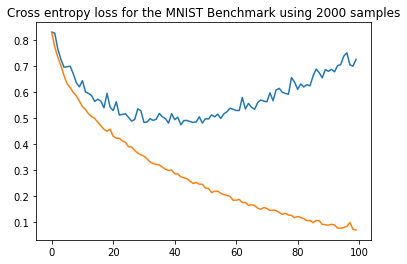

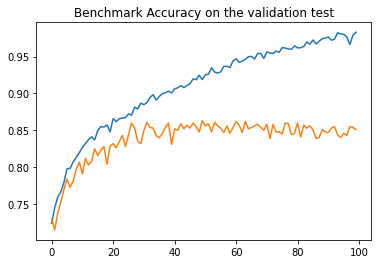

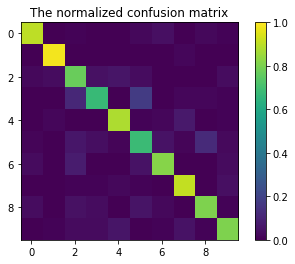

In [8]:
model(data_patched[[0]].to(device))
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training_acc'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Benchmark Accuracy on the validation test')
pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)

plt.figure()
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),
          vmin=0,vmax=1)
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')


### Hybrid1 Training

In [6]:
model = HViT(n,d,n_layers=n_layers,n_h=n_h,FC_layers=FC_layers,attention_type='hybrid1').to(device)
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

NameError: name 'circuit_to_layer' is not defined

# of parameters: 7514
Wrongly Predicted Ratio:0.1542909090909091


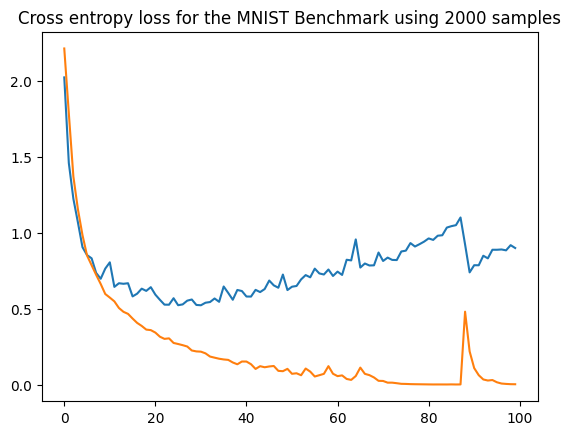

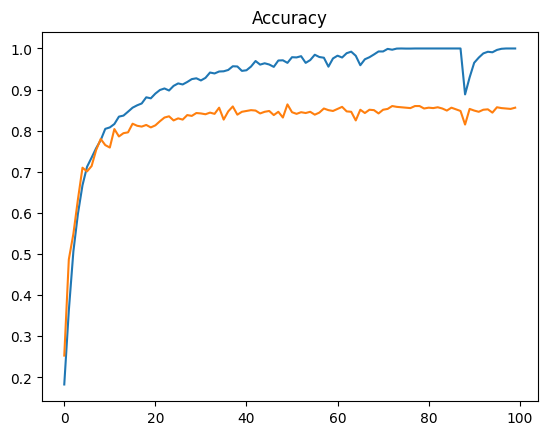

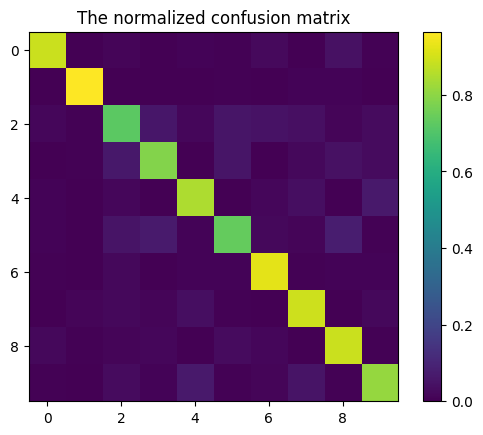

In [20]:
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
model.load_state_dict(torch.load('best_state_on_training'))
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()
pred = model(test_set.dataset.data[test_set.indices].to(device)).cpu().argmax(axis=1)
plt.imshow(sklearn.metrics.confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices],normalize='true'))
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices]).sum()/pred.shape[0]}')


### Hybrid2 Training

In [6]:
transformer_dims = {'Token_Dim':data_patched.shape[-2],'Image_Dim':data_patched.shape[-1]}
transformer_hyper = {'n_layers':4,'FC_layers':[10],
                    'head_dimension':8,'Embed_Dim': 32,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

In [7]:
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)


/home/eyup.unlu/QViT_HEP_ML4Sci/QViT/model.py:58: UserWarning: ff_dim is not utilized since no ff
  if ff_dim is not None:warnings.warn("ff_dim is not utilized since no ff")
/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
optim = torch.optim.Adam(model.parameters(),lr=1e-3)
n_epochs = 100
loss_fn = nn.CrossEntropyLoss(reduction='none')
history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

# of parameters: 3338
Wrongly Predicted Ratio:0.199


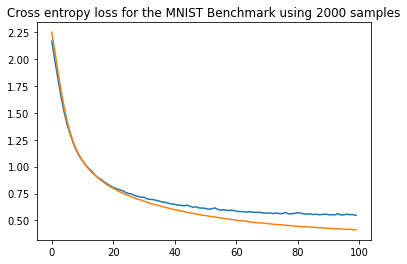

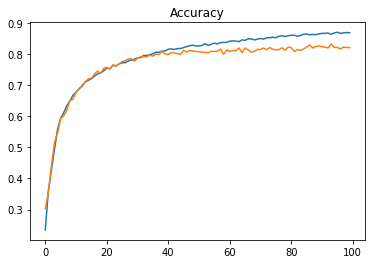

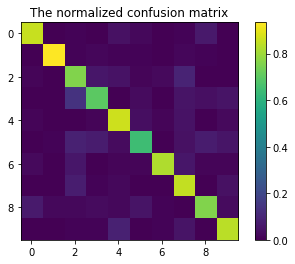

In [14]:
model.load_state_dict(torch.load('best_state_on_training_acc_mnist'))
print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
history = torch.load('temp_history')
plt.plot(history['val'],label='val_loss')
plt.plot(history['tr'],label='tr_loss')
plt.title('Cross entropy loss for the MNIST Benchmark using 2000 samples')
plt.figure()
plt.plot(history['tr_acc'],label='val')
plt.plot(history['val_acc'],label='tr')
plt.title('Accuracy')
plt.figure()
with torch.no_grad():pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'))
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')


In [15]:
max(history['val_acc']),1-(pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]

(tensor(0.8320), tensor(0.8010))

## Jet Classifier 

### Initization

In [6]:
model_hist = 'Model_Hist/'
fig_file = 'Figures/'

In [20]:
e = h5py.File('../electron.hdf5')
p = h5py.File('../photon.hdf5')
# n_data=int(1e5)
data = torch.cat([torch.from_numpy(e['X'][:][:]),torch.from_numpy(p['X'][:][:])],axis=0).type(torch.get_default_dtype())#[:n_data]
targets = torch.cat([torch.from_numpy(e['y'][:][:]),torch.from_numpy(p['y'][:][:])],axis=0).type(torch.get_default_dtype())#[:n_data]           
e.close()
p.close()

In [8]:
mean = data.amax(dim=[1,2]).mean(axis=0)
std = data.amax(dim=[1,2]).std(axis=0)


In [9]:
tr_len = round(data.shape[0]*.8)//2*2
val_len = (data.shape[0]-tr_len)//2


# data_patched = patcher_with_color((data-mean[None,None,None,:])/std[None,None,None,:],[4,8])

j_min = data.abs().amin(dim=[0,1,2])[None,None,None,:]
j_range = data.amax(dim=[0,1,2])[None,None,None,:] - data.abs().amin(dim=[0,1,2])[None,None,None,:]
data = (data-j_min)/j_range


In [10]:
r,c=4,8

In [11]:
# Below is only energy
def patcher_with_color(data,sh):
    r,c = sh

    rmax = (data.shape[-3]//r)
    cmax = (data.shape[-2]//c)

    patched = torch.empty(*data.shape[:-3],rmax*cmax,r*c,device=data.device,dtype=torch.get_default_dtype())
    n=0
    for i in range(rmax):
        for j in range(cmax):
                
            patched[...,n,:] = data[...,(i*r):(i*r+r),(j*c):(j*c+c),0].flatten(start_dim = -2)
            n+=1
    return patched

In [12]:
data_patched = patcher_with_color(data,[4,8])
del data
data_patched[data_patched.isnan()]=0

In [13]:
torch.manual_seed(0)
batch_size=512
# batch_size=256

jet_simple = simple_dataset(data_patched.type(torch.get_default_dtype()),targets.type(torch.get_default_dtype()))

tr_set,val_set,test_set = torch.utils.data.random_split(jet_simple,[tr_len,val_len,val_len])
tr_set.indices = tr_set.indices[:(len(tr_set.indices)//batch_size)*batch_size] 
val_set.indices = val_set.indices[:(len(val_set.indices)//batch_size)*batch_size] 
test_set.indices = test_set.indices[:(len(val_set.indices)//batch_size)*batch_size] 

tr_dl = DataLoader(tr_set,batch_size=batch_size,shuffle=True)
val_dl = DataLoader(val_set,batch_size=batch_size,shuffle=True)
test_dl = DataLoader(test_set,batch_size=batch_size,shuffle=True)
del data_patched

In [14]:
print(len(tr_set.indices),len(val_set.indices),len(test_set.indices))#398336 49664 49664

398336 49664 49664


In [15]:
transformer_dims = {'Token_Dim':jet_simple.data.shape[-2],'Image_Dim':jet_simple.data.shape[-1]}

In [16]:
transformer_hyper = {'n_layers':5,'FC_layers':[32,1],
                    'head_dimension':4,'Embed_Dim': 16,'ff_dim':16}
transformer_type = {'classifying_type':'cls_token','pos_embedding':False}
n_epochs =40
def loss_fn(yhat,y):
    return nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),y.float())

### Classic

#### Training

In [23]:
for act_type in ['max','mean','cls_token']:

    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=True
    torch.manual_seed(0)
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
    optim = torch.optim.Adam(model.parameters(),lr=5e-3)

    history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)
    model.load_state_dict(torch.load('best_state_on_training_acc'))
    torch.save(model.state_dict(),'cls_model_'+act_type)
    torch.save(history,'cls_hist_'+act_type)
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4785


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4785


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4801


In [24]:
for act_type in ['max','mean','cls_token']:
    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=False
    torch.manual_seed(0)
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
    optim = torch.optim.Adam(model.parameters(),lr=5e-3)
    def loss_fn(yhat,y):
        return nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),y.float())
    
    history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)
    model.load_state_dict(torch.load('best_state_on_training_acc'))
    torch.save(model.state_dict(),'cls_model_'+act_type+'_no_pos_embedding')
    torch.save(history,'cls_hist_'+act_type+'_no_pos_embedding')
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4785


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4785


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

# of parameters| 4801


#### Evals

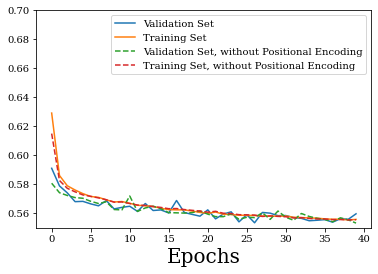

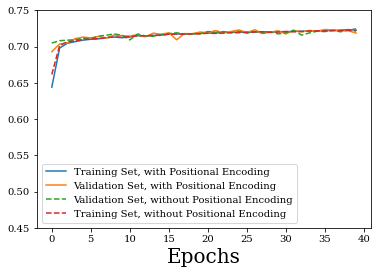

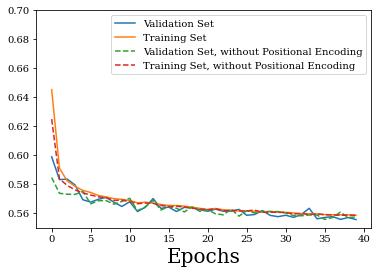

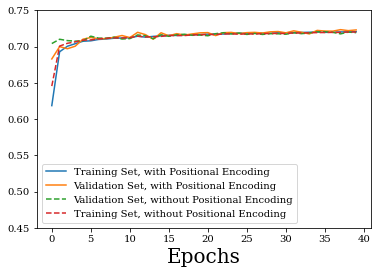

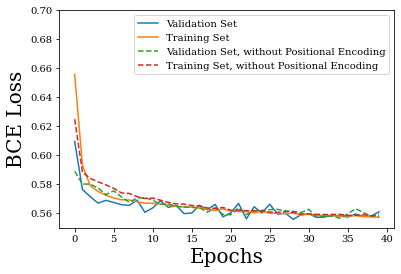

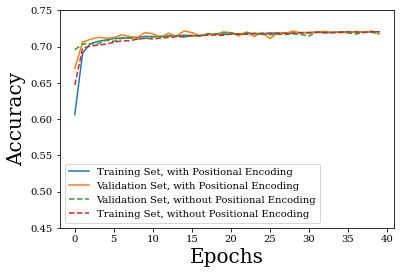

In [15]:

label_size=20
for act_type in ['max','mean','cls_token']:
    history = torch.load(model_hist+'cls_hist_'+act_type)
    history_no_pos = torch.load(model_hist+'cls_hist_'+act_type+'_no_pos_embedding')

    
    plt.figure()
    
    plt.plot(history['val'],label='Validation Set')
    plt.plot(history['tr'],label='Training Set')
    plt.plot(history_no_pos['val'],'--',label='Validation Set, without Positional Encoding')
    plt.plot(history_no_pos['tr'],'--',label='Training Set, without Positional Encoding')
    plt.ylim([0.55,0.7])
    plt.xlabel('Epochs',size=label_size)
    plt.legend()
    if act_type == 'cls_token':
        plt.ylabel('BCE Loss',size=label_size)
        
    plt.savefig(fig_file+"cls_loss_"+act_type+".jpg",bbox_inches='tight')
    plt.figure()
    plt.plot(history['tr_acc'],label='Training Set, with Positional Encoding')
    plt.plot(history['val_acc'],label='Validation Set, with Positional Encoding')
    plt.plot(history_no_pos['val_acc'],'--',label='Validation Set, without Positional Encoding')
    plt.plot(history_no_pos['tr_acc'],'--',label='Training Set, without Positional Encoding')
    plt.xlabel('Epochs',size=label_size)
    plt.ylim([0.45,0.75])
    plt.legend()
    
    if act_type == 'cls_token':
        plt.ylabel('Accuracy',size=label_size)


    plt.savefig(fig_file+"cls_acc_"+act_type+".jpg",bbox_inches='tight')
    
    


In [17]:

label_size=20
print('Position Embedding')
for act_type in ['cls_token','max','mean']:
    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=True
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
    model.load_state_dict(torch.load(model_hist+'cls_model_'+act_type))
    
    
    pred=[]
    real=[]
    test_dl = DataLoader(test_set,batch_size=batch_size,shuffle=False)
    with torch.no_grad():

        for i in test_dl:
            pred.append(model(i['input'].to(device)).cpu())
            real.append(i['output'])
    yhat = torch.cat(pred).cpu()
    y = test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()
    acc = (torch.sigmoid(yhat)>=.5).squeeze()
    print(act_type)
    
    print((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']).float().mean())
    print(nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()).mean())
    print(roc_auc_score(test_dl.dataset.dataset[test_dl.dataset.indices]['output'],torch.cat(pred).cpu().numpy()))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

    
   

Position Embedding


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


cls_token
tensor(0.7171)
tensor(0.5639, dtype=torch.float64)
0.7799209531633954
# of parameters| 4801


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


max
tensor(0.7178)
tensor(0.5618, dtype=torch.float64)
0.7832748866339052
# of parameters| 4785


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


mean
tensor(0.7202)
tensor(0.5593, dtype=torch.float64)
0.7838565017825356
# of parameters| 4785


In [18]:
electron_correct=torch.where((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']))[0][torch.sigmoid(yhat[(acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output'])]).argmax()]
photon_correct=torch.where((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']))[0][torch.sigmoid(yhat[(acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output'])]).argmin()]
electron_wrong=torch.where((acc!=test_dl.dataset.dataset[test_dl.dataset.indices]['output']))[0][torch.sigmoid(yhat[(acc!=test_dl.dataset.dataset[test_dl.dataset.indices]['output'])]).argmin()]
photon_wrong=torch.where((acc!=test_dl.dataset.dataset[test_dl.dataset.indices]['output']))[0][torch.sigmoid(yhat[(acc!=test_dl.dataset.dataset[test_dl.dataset.indices]['output'])]).argmax()]



/scratch/local/22206980/ipykernel_3739654/986445579.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data[j,...,0].numpy()/data[j,...,0].max().numpy()))


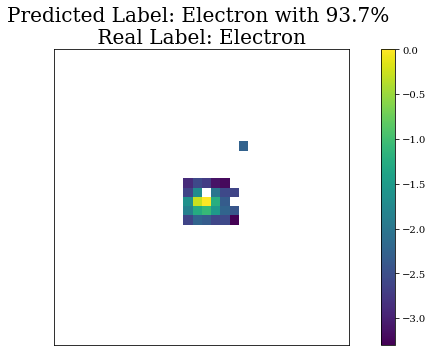

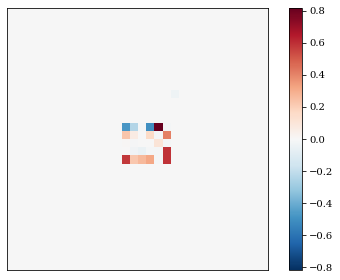

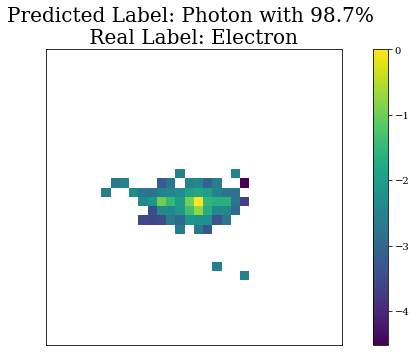

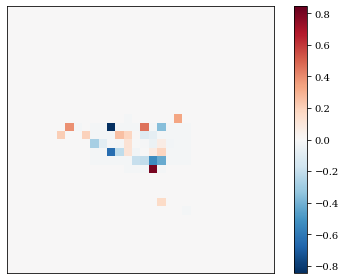

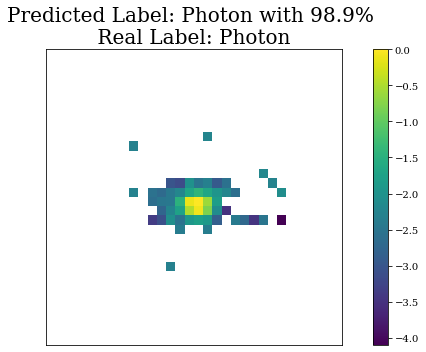

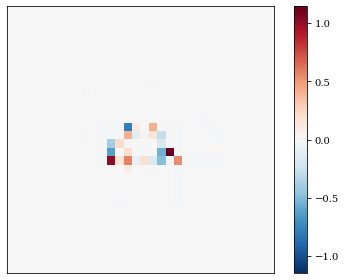

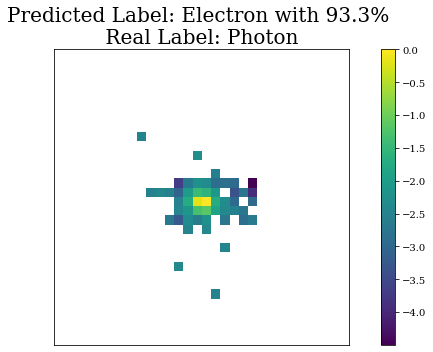

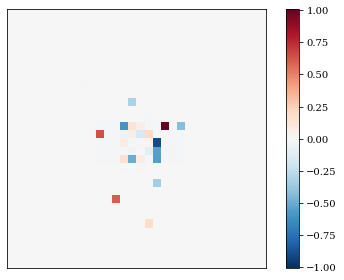

In [28]:
index_labels = ['electron_correct','electron_wrong','photon_correct','photon_wrong']
for i,j in enumerate([electron_correct,electron_wrong,photon_correct,photon_wrong]):
    plt.figure(figsize=(9,5))
    plt.imshow(np.log10(data[j,...,0].numpy()/data[j,...,0].max().numpy()))
    plt.colorbar()
    label = 'Electron' if torch.sigmoid(yhat[j])>=.5 else 'Photon'
    real_label = 'Electron' if y[j]==1 else 'Photon'
    prob = np.round(np.max( [torch.sigmoid(yhat[j]).item(),1-torch.sigmoid(yhat[j]).item() ])*100,1)
    plt.title(f'Predicted Label: {label} with {prob}% \n Real Label: {real_label} ',size=20)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(index_labels[i]+'.png',bbox_inches='tight')
    plt.figure()
    plt.imshow(data[j,...,1],vmin=-data[j,...,1].abs().max(),vmax=data[j,...,1].abs().max(),cmap='RdBu_r')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(index_labels[i]+'_time.png',bbox_inches='tight')

In [38]:
label_size=20
print('Without Position Embedding')
for act_type in ['cls_token','max','mean']:
    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=False
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
    model.load_state_dict(torch.load(model_hist+'cls_model_'+act_type+'_no_pos_embedding'))
    
    
    pred=[]
    real=[]
    test_dl = DataLoader(test_set,batch_size=batch_size,shuffle=False)
    with torch.no_grad():

        for i in test_dl:
            pred.append(model(i['input'].to(device)).cpu())
            real.append(i['output'])
    yhat = torch.cat(pred).cpu()
    y = test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()
    acc = (torch.sigmoid(yhat)>=.5).squeeze()
    print(act_type)
    
    print((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']).float().mean())
    print(nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()).mean())
    print(roc_auc_score(test_dl.dataset.dataset[test_dl.dataset.indices]['output'],torch.cat(pred).cpu().numpy()))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

    
   

Without Position Embedding


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


cls_token
tensor(0.7195)
tensor(0.5606, dtype=torch.float64)
0.7826306395381529
# of parameters| 4801


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


max
tensor(0.7218)
tensor(0.5572, dtype=torch.float64)
0.7862328871097394
# of parameters| 4785


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


mean
tensor(0.7195)
tensor(0.5603, dtype=torch.float64)
0.7827982886538883
# of parameters| 4785


### Hybrid2

#### Training

In [ ]:
for act_type in ['max','mean','cls_token']:

    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=True
    
    torch.manual_seed(0)
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
    
    model(jet_simple.data[0].unsqueeze(0).to(device))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')
    
    optim = torch.optim.Adam(model.parameters(),5e-3)
    history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)
    model.load_state_dict(torch.load('best_state_on_training_acc'))
    torch.save(model.state_dict(),'qml_model_'+act_type)
    torch.save(history,'qml_hist_'+act_type)


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
for act_type in ['max','mean','cls_token']:

    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=False
    
    torch.manual_seed(0)
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
    
    model(jet_simple.data[0].unsqueeze(0).to(device))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')
    
    optim = torch.optim.Adam(model.parameters(),5e-3)
    history = train(model,tr_dl,val_dl,loss_fn,optim,n_epochs,device=device)
    model.load_state_dict(torch.load('best_state_on_training_acc'))
    torch.save(model.state_dict(),'qml_model_'+act_type+'_no_pos_embedding')
    torch.save(history,'qml_hist_'+act_type+'_no_pos_embedding')


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# of parameters| 4601


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

  0%|          | 0/778 [00:00<?, ?it/s]

#### Evals

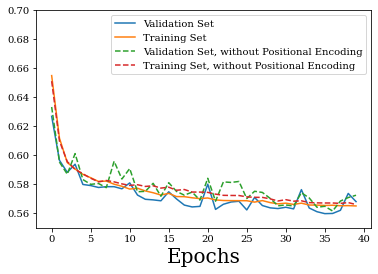

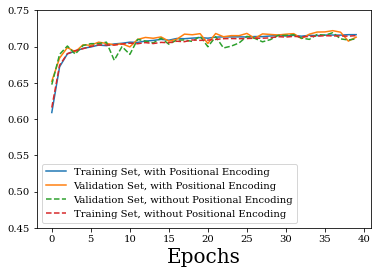

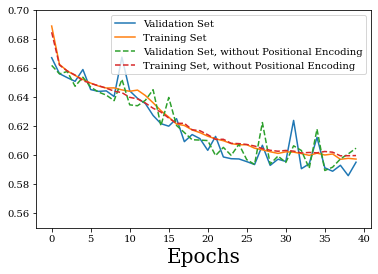

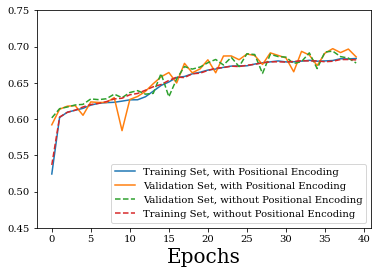

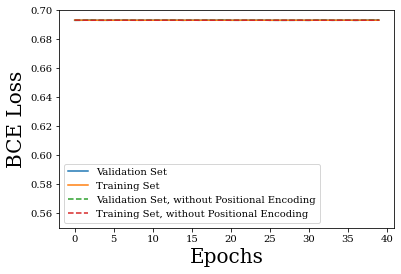

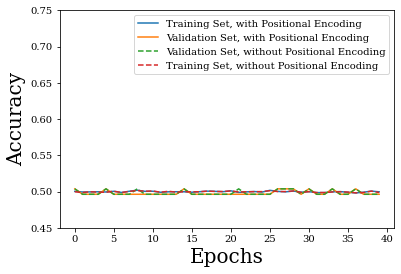

In [43]:

label_size=20
for act_type in ['max','mean','cls_token']:
    history = torch.load(model_hist+'qml_hist_'+act_type)
    history_no_pos = torch.load(model_hist+'qml_hist_'+act_type+'_no_pos_embedding')

    
    plt.figure()
    
    plt.plot(history['val'],label='Validation Set')
    plt.plot(history['tr'],label='Training Set')
    plt.plot(history_no_pos['val'],'--',label='Validation Set, without Positional Encoding')
    plt.plot(history_no_pos['tr'],'--',label='Training Set, without Positional Encoding')
    plt.ylim([0.55,0.7])
    plt.xlabel('Epochs',size=label_size)
    plt.legend()
    if act_type == 'cls_token':
        plt.ylabel('BCE Loss',size=label_size)
        
    plt.savefig(fig_file+"qml_loss_"+act_type+".jpg",bbox_inches='tight')
    plt.figure()
    plt.plot(history['tr_acc'],label='Training Set, with Positional Encoding')
    plt.plot(history['val_acc'],label='Validation Set, with Positional Encoding')
    plt.plot(history_no_pos['val_acc'],'--',label='Validation Set, without Positional Encoding')
    plt.plot(history_no_pos['tr_acc'],'--',label='Training Set, without Positional Encoding')
    plt.xlabel('Epochs',size=label_size)
    plt.ylim([0.45,0.75])
    plt.legend()
    
    if act_type == 'cls_token':
        plt.ylabel('Accuracy',size=label_size)


    plt.savefig(fig_file+"qml_acc_"+act_type+".jpg",bbox_inches='tight')
    
    


In [41]:
label_size=20
for act_type in ['cls_token','max','mean']:
    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=True
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
    model.load_state_dict(torch.load(model_hist+'qml_model_'+act_type))
    
    
    pred=[]
    real=[]
    test_dl = DataLoader(test_set,batch_size=batch_size,shuffle=False)
    with torch.no_grad():

        for i in test_dl:
            pred.append(model(i['input'].to(device)).cpu())
            real.append(i['output'])
    yhat = torch.cat(pred).cpu()
    y = test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()
    acc = (torch.sigmoid(yhat)>=.5).squeeze()
    print(act_type)
    
    print((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']).float().mean())
    print(nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()).mean())
    print(roc_auc_score(test_dl.dataset.dataset[test_dl.dataset.indices]['output'],torch.cat(pred).cpu().numpy()))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

    
   

cls_token
tensor(0.5020)
tensor(0.6931, dtype=torch.float64)
0.5014105940534123
# of parameters| 4601


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


max
tensor(0.7183)
tensor(0.5650, dtype=torch.float64)
0.7793296342795084
# of parameters| 4585


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


mean
tensor(0.6959)
tensor(0.5920, dtype=torch.float64)
0.7506505273188293
# of parameters| 4585


In [42]:
label_size=20
for act_type in ['cls_token','max','mean']:
    transformer_type['classifying_type']=act_type
    transformer_type['pos_embedding']=False
    model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
    model.load_state_dict(torch.load(model_hist+'qml_model_'+act_type+'_no_pos_embedding'))
    
    
    pred=[]
    real=[]
    test_dl = DataLoader(test_set,batch_size=batch_size,shuffle=False)
    with torch.no_grad():

        for i in test_dl:
            pred.append(model(i['input'].to(device)).cpu())
            real.append(i['output'])
    yhat = torch.cat(pred).cpu()
    y = test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()
    acc = (torch.sigmoid(yhat)>=.5).squeeze()
    print(act_type)
    
    print((acc==test_dl.dataset.dataset[test_dl.dataset.indices]['output']).float().mean())
    print(nn.BCEWithLogitsLoss(reduction='none')(yhat.squeeze(),test_dl.dataset.dataset[test_dl.dataset.indices]['output'].double()).mean())
    print(roc_auc_score(test_dl.dataset.dataset[test_dl.dataset.indices]['output'],torch.cat(pred).cpu().numpy()))
    print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters() if i.requires_grad])}')

    
   

/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


cls_token
tensor(0.5020)
tensor(0.6931, dtype=torch.float64)
0.49992685830835903
# of parameters| 4601


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


max
tensor(0.7180)
tensor(0.5654, dtype=torch.float64)
0.7787903605651461
# of parameters| 4585


/home/eyup.unlu/.local/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


mean
tensor(0.6924)
tensor(0.5948, dtype=torch.float64)
0.747804065064415
# of parameters| 4585


# Grad Experiments

In [59]:
model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)
yhat= model(jet_simple.data[0].unsqueeze(0).to(device))
# loss = loss_fn(yhat,jet_simple.target[0].to(device))
# loss.backward(retain_graph=True)
# for i in model.parameters():
#     if i.grad is None and i.requires_grad is True: print('Oh no')


In [53]:
print(f'# of parameters| {sum([np.prod(i.shape) for i in model.parameters()  if i.requires_grad])}')

# of parameters| 4801


In [47]:
print(f'# of parameters| {sum([np.prod(i.shape) for i in model.transformer.encoder_layers[0].parameters()  if i.requires_grad])}')

# of parameters| 736


In [23]:
[i.requires_grad for i in model.transformer.encoder_layers[0].parameters() if i.grad is None]

[False]